<a href="https://colab.research.google.com/github/jiyanshud22/Saltmine-Auto-Stacking/blob/main/AR1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AR1

---

## Input File Structure

**Program Table Input 2 - Floor**

* `Name`: Floor identifier
* `Usable_Area`: Available space
* `Max_Assignable_Floor_loading_Capacity`: Occupancy limit

**Program Table Input 1 - Block**

* `Block_ID`, `Department_Sub-Department`, `Block_Name`
* `Typical_Destination`: Indicates whether a block is destination or typical
* `Destination_Group`: Grouping for destination blocks
* `Cumulative_Block_Circulation_Area`, `Max_Occupancy_with_Capacity`
* `SpaceMix_(ME_WE_US_Support_Speciality)`: Category label

**Department Split**

* Maps each sub-department to whether its blocks can be split and the minimum percentage per department.

**Adjacency**

* A matrix of scores indicating which blocks should remain together.

**De-Centralized Logic**

* Specifies adjustments to the number of destination floors for semi- and de-centralized modes.
---

## Customization

* **Organizational modes**: Adjust parameters for centralized, semi-centralized, and decentralized setups.

---

## Process Outline

1. **Data Import**

   * Load each sheet and clean column names.
   * Coerce numeric values and strip whitespace.

2. **Preprocessing**

   * Filter blocks into `destination` and `typical` sets based on their labels.
   * Build lookup tables for department-split rules and decentralization adjustments.

3. **Initialization**

   * For each floor, record remaining area, capacity, and initialize empty assignment lists.

4. **Allocation Algorithm**

   * **Phase 1 (Destination Placement)**: Place each destination group whole, checking capacity and area constraints.
   * **Phase 2 (Typical Distribution)**: Compute proportional targets based on available area, adjust rounding errors, and assign individual blocks.

5. **Summary Construction**

   * Compile detailed assignment lists, per-floor summaries, category breakdowns, and any unassigned blocks.

6. **Export**

   * Generate three Excel workbooks (`centralized`, `semi-centralized`, `decentralized`) containing:

     * Detailed assignments
     * Floor summaries
     * Category mix tables
     * Unassigned block listings

---

## Logic

**Destination Group Totals**

* Group area: \$A\_g = \sum\_{b \in g} A\_b\$
* Group capacity: \$C\_g = \sum\_{b \in g} C\_b\$

**Typical Blocks Distribution**

1. Floor share ratio: \$r\_i = a\_i / \sum\_j a\_j\$
2. Raw count: \$x\_i = r\_i \times N\$
3. Rounded target: \$t\_i = \mathrm{round}(x\_i)\$
4. Error correction: \$d = N - \sum\_i t\_i\$, fractional parts \$f\_i = x\_i - \lfloor x\_i\rfloor\$

   * If \$d > 0\$, increment the \$d\$ floors with highest \$f\_i\$.
   * If \$d < 0\$, decrement the \$|d|\$ floors with lowest \$f\_i\$.

**Placement Constraints**

* A block \$b\$ fits on floor \$i\$ only if:
  $a_i \ge A_b \quad\text{and}\quad c_i \ge C_b$

**Summary Metrics**

* Number of blocks on floor \$i\$: \$n\_i = \sum\_{b \in f\_i} 1\$
* Total assigned area: \$A\_i = \sum\_{b \in f\_i} A\_b\$
* Total occupancy load: \$C\_i = \sum\_{b \in f\_i} C\_b\$


---


# Stacking process sequence:


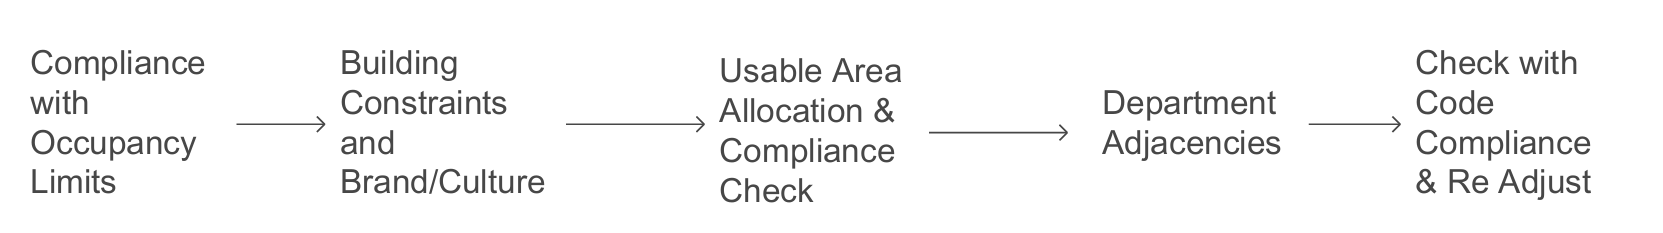

# 3 different outputs based on
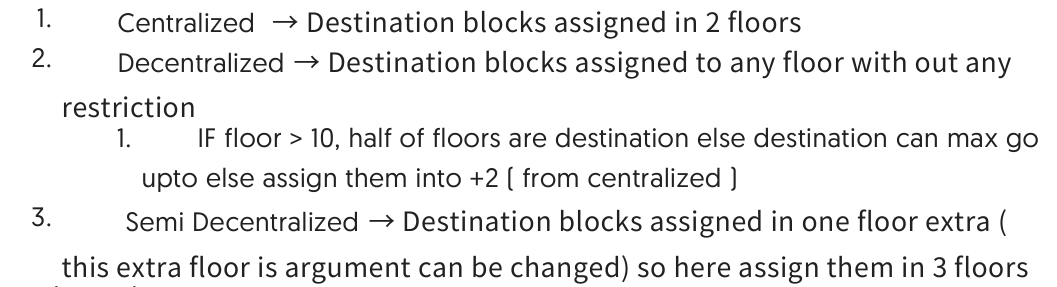

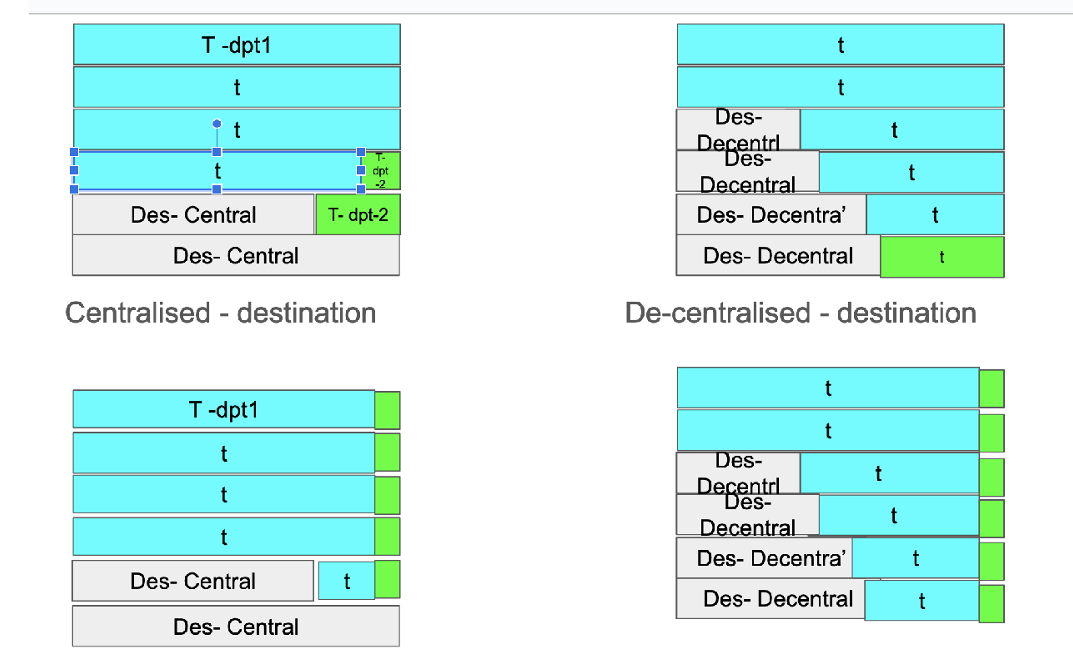


---

## strict constraints:

* **Departmental matching**
* **Space category compatibility**
* **Available capacity (area-wise)**

---

##  Section I: **Data Structures and Variables**

Let’s denote your two key datasets as mathematical objects.

---

### ✅ 1. Blocks (From `block_df`)

Each block $b_i \in \mathcal{B}$ is represented by:

* $A_i$: Area of block
* $D_i$: Department label (e.g., “Admin”)
* $C_i$: Space Mix Category (e.g., “Core”)

So, the full **block matrix** is:

$$
\mathcal{B} =
\left\{
b_i = (A_i, D_i, C_i) \mid i = 1, \dots, N
\right\}
$$

Where:

* $N$: Total number of blocks

---

### ✅ 2. Floors (From `floor_df`)

Each floor $f_j \in \mathcal{F}$ has:

* $\text{Cap}_j$: Total capacity (area)
* $D_j$: Department label
* $C_j$: Space Mix Category
* $U_j$: Area used so far (initialized as 0)

The floor matrix:

$$
\mathcal{F} =
\left\{
f_j = (\text{Cap}_j, D_j, C_j, U_j = 0) \mid j = 1, \dots, M
\right\}
$$

Where:

* $M$: Total number of floors

---

### ✅ 3. Auxiliary Structures

* $\phi: \mathcal{B} \to \mathcal{F} \cup \{ \emptyset \}$: Mapping from block to floor (assignment)
* $\text{UsedArea}_j = U_j$: Area used on floor $j$

---

##  Section II: **Core Matching and Assignment Logic**

---

we find a **valid assignment** $\phi(b_i) = f_j$ for each block such that:

#### 1. Categorical Match:

* $D_i = D_j$: Department compatibility
* $C_i = C_j$: Space category compatibility

#### 2. Area Capacity Constraint:

Let:

* $A_i$: Area of block
* $U_j$: Current used area on floor $j$
* $\text{Cap}_j$: Capacity of floor

Then:

$$
A_i + U_j \leq \text{Cap}_j
$$

---

## Section III: **Conditional Expressions**

---

### ✅ 1. Feasibility Condition for Assignment

For a block $b_i$ to be assigned to floor $f_j$:

$$
\text{Feasible}_{i,j} =
\begin{cases}
1 & \text{if } D_i = D_j \land C_i = C_j \land (U_j + A_i) \leq \text{Cap}_j \\
0 & \text{otherwise}
\end{cases}
$$

---

### ✅ 2. Assignment Function

$$
\phi(b_i) = \min \left\{ f_j \in \mathcal{F} \mid \text{Feasible}_{i,j} = 1 \right\}
$$

You assign the block to the **first floor** that satisfies all criteria.

---

### ✅ 3. Update Rule After Assignment

Once $b_i$ is assigned to $f_j$:

$$
U_j \leftarrow U_j + A_i
$$

This ensures used area is cumulative and subsequent assignments respect updated capacity.

---

### ✅ 4. Rejection Condition

If $\phi(b_i) = \emptyset$, the block is **unassigned**. You log this.

---

##  Section IV: **Outputs**

---

You generate a table containing:

$$
\left( \text{Block Name}, A_i, D_i, C_i, \phi(b_i) \right)
$$

And a list of unassigned blocks:

$$
\mathcal{B}_\text{unassigned} = \{ b_i \in \mathcal{B} \mid \phi(b_i) = \emptyset \}
$$

---

##  Section V: **Space Utilization Metric (Optional)**

utilization of a floor is:

$$
\text{Utilization}_j = \frac{U_j}{\text{Cap}_j} \times 100\%
$$

And for total system:

$$
\text{System Utilization} = \frac{\sum_{j=1}^{M} U_j}{\sum_{j=1}^{M} \text{Cap}_j}
$$


---

##  Section VII: **Algorithm Type**

This algorithm is a **greedy constrained bin-packing with categorical filters**:

* **Greedy**: Assign to first matching floor
* **Bin-packing**: Floors are bins, blocks are items
* **Constraints**: Category match, department match, and space fit

It is **not most optimal**, but **fast and practical** for planning.

---

## ✅ Summary Table of Mathematical Constructs

| Term                              | Description                 |
| --------------------------------- | --------------------------- |
| $\mathcal{B}$                     | Set of all blocks           |
| $\mathcal{F}$                     | Set of all floors           |
| $A_i$                             | Area of block $i$           |
| $\text{Cap}_j$                    | Capacity of floor $j$       |
| $U_j$                             | Used area on floor $j$      |
| $D_i, D_j$                        | Department of block/floor   |
| $C_i, C_j$                        | Category of block/floor     |
| $\phi(b_i)$                       | Floor assigned to block $i$ |
| $\mathcal{B}_{\text{unassigned}}$ | Set of unassigned blocks    |

---


In [ ]:


import pandas as pd
import random
import math

# ----------------------------------------
# Step 1: Load Input Sheets
# ----------------------------------------

# excel_path: String representing the file path to the input Excel file containing multiple sheets with data
excel_path = '/content/AR--1.xlsx'  # ← adjust if needed

# 1.1 Floors sheet
# all_floor_data: DataFrame containing data from the 'Program Table Input 2 - Floor' sheet, with floor-related information
all_floor_data = pd.read_excel(excel_path, sheet_name='Program Table Input 2 - Floor')
# Strip whitespace from column names in all_floor_data for consistency
all_floor_data.columns = all_floor_data.columns.str.strip()

# 1.2 Blocks sheet
# all_block_data: DataFrame containing data from the 'Program Table Input 1 - Block' sheet, with block-related information
all_block_data = pd.read_excel(excel_path, sheet_name='Program Table Input 1 - Block')
# Strip whitespace from column names in all_block_data for consistency
all_block_data.columns = all_block_data.columns.str.strip()

# 1.3 Department Split sheet
# department_split_data: DataFrame containing data from the 'Department Split' sheet, with department and sub-department information, skipping the first row
department_split_data = pd.read_excel(excel_path, sheet_name='Department Split', skiprows=1)
# Strip whitespace from column names in department_split_data for consistency
department_split_data.columns = department_split_data.columns.str.strip()
# Rename the 'BU_Department_Sub-Department' column to 'Department_Sub-Department' for clarity
department_split_data = department_split_data.rename(
    columns={'BU_Department_Sub-Department': 'Department_Sub-Department'}
)

# 1.4 Adjacency sheet
# xls: ExcelFile object representing the loaded Excel file for accessing sheet names
xls = pd.ExcelFile(excel_path)
# adjacency_sheet_name: String containing the name of the sheet that includes "Adjacency" in its title
adjacency_sheet_name = [name for name in xls.sheet_names if "Adjacency" in name][0]
# raw_data: DataFrame containing raw data from the adjacency sheet, parsed with header at row 1 and first column as index
raw_data = xls.parse(adjacency_sheet_name, header=1, index_col=0)
# adjacency_data: DataFrame with numeric values from raw_data, with non-numeric values converted to NaN
adjacency_data = raw_data.apply(pd.to_numeric, errors='coerce')
# Strip whitespace from index and column names in adjacency_data for consistency
adjacency_data.index = adjacency_data.index.str.strip()
adjacency_data.columns = adjacency_data.columns.str.strip()

# 1.5 De-Centralized Logic sheet
# df_logic: DataFrame containing data from the 'De-Centralized Logic' sheet, with no header
df_logic = pd.read_excel(excel_path, sheet_name='De-Centralized Logic', header=None)
# De_Centralized_data: Dictionary to store centralized, semi-centralized, and decentralized logic data, with keys for each mode and their respective values
De_Centralized_data = {}
# current_section: String to track the current section being processed (Centralised, Semi Centralized, or DeCentralised)
current_section = None
for _, row in df_logic.iterrows():
    # first_cell: String containing the value of the first column in the current row, stripped of whitespace
    first_cell = str(row[0]).strip() if pd.notna(row[0]) else ""
    if first_cell in ["Centralised", "Semi Centralized", "DeCentralised"]:
        # Update current_section to the current mode (Centralised, Semi Centralized, or DeCentralised)
        current_section = first_cell
        # Initialize a dictionary for the current section with an 'Add' key set to 0
        De_Centralized_data[current_section] = {"Add": 0}
    elif current_section and first_cell == "( Add into cetralised destination Block)":
        # Set the 'Add' value for the current section to the integer value in the second column, or 0 if NaN
        De_Centralized_data[current_section]["Add"] = int(row[1]) if pd.notna(row[1]) else 0

# Ensure all expected keys exist in De_Centralized_data
for key in ["Centralised", "Semi Centralized", "DeCentralised"]:
    if key not in De_Centralized_data:
        # Initialize missing key with 'Add' set to 0
        De_Centralized_data[key] = {"Add": 0}
    elif "Add" not in De_Centralized_data[key]:
        # Ensure 'Add' key exists for each section, set to 0 if missing
        De_Centralized_data[key]["Add"] = 0

# ----------------------------------------
# Step 2: Preprocess Blocks & Department Split
# ----------------------------------------

# 2.1 Convert cumulative circulation area from SQFT to SQM (commented out in original code)
# all_block_data['Cumulative_Area_SQM']: New column in all_block_data to store converted area values in square meters
# all_block_data['Cumulative_Area_SQM'] = (
#     all_block_data['Cumulative_Block_Circulation_Area_(SQM)']
# )

# 2.2 Separate Destination vs. Typical blocks
# destination_blocks: DataFrame containing blocks marked as 'Destination' or 'both' in the 'Typical_Destination' column
destination_blocks = all_block_data[all_block_data['Typical_Destination'].isin(['Destination', 'both'])].copy()
# typical_blocks: DataFrame containing blocks marked as 'Typical' in the 'Typical_Destination' column
typical_blocks = all_block_data[
    all_block_data['Typical_Destination'] == 'Typical'
].copy()

# ----------------------------------------
# Step 3: Initialize Floor Assignments
# ----------------------------------------

def initialize_floor_assignments(floor_df):
    """
    Initializes a dictionary for floor assignments.

    Args:
        floor_df: DataFrame containing floor data with columns like 'Name', 'Usable_Area', and 'Max_Assignable_Floor_loading_Capacity'

    Returns:
        assignments: Dictionary keyed by floor name, each entry containing:
            - remaining_area: Float, remaining usable area on the floor
            - remaining_capacity: Integer, remaining occupancy capacity
            - assigned_blocks: List of dictionaries, blocks assigned to the floor
            - assigned_departments: Set of strings, unique departments assigned
            - ME_area, WE_area, US_area, Support_area, Speciality_area: Floats, area assigned to each space mix category
    """
    # assignments: Dictionary to store floor assignment details
    assignments = {}
    for _, row in floor_df.iterrows():
        # floor: String, name of the floor from the 'Name' column, stripped of whitespace
        floor = row['Name'].strip()
        assignments[floor] = {
            # remaining_area: Float, initial usable area available on the floor
            'remaining_area': row['Usable_Area'],
            # remaining_capacity: Integer, maximum assignable occupancy capacity of the floor
            'remaining_capacity': row['Max_Assignable_Floor_loading_Capacity'],
            # assigned_blocks: List to store dictionaries of blocks assigned to this floor
            'assigned_blocks': [],
            # assigned_departments: Set to store unique department names assigned to this floor
            'assigned_departments': set(),
            # ME_area: Float, total area for 'ME' space mix category on this floor
            'ME_area': 0.0,
            # WE_area: Float, total area for 'WE' space mix category on this floor
            'WE_area': 0.0,
            # US_area: Float, total area for 'US' space mix category on this floor
            'US_area': 0.0,
            # Support_area: Float, total area for 'Support' space mix category on this floor
            'Support_area': 0.0,
            # Speciality_area: Float, total area for 'Speciality' space mix category on this floor
            'Speciality_area': 0.0
        }
    return assignments

# floors: List of floor names extracted from the assignments dictionary
floors = list(initialize_floor_assignments(all_floor_data).keys())

# ----------------------------------------
# Step 4: Core Stacking Function
# ----------------------------------------

def run_stack_plan(mode):
    """
    Generates a stack plan based on the specified mode.

    Args:
        mode: String, one of 'centralized', 'semi', or 'decentralized'

    Returns:
        detailed_df: DataFrame with block assignments (floor, department, block name, etc.)
        floor_summary_df: DataFrame with floor-wise totals (block count, area, occupancy)
        space_mix_df: DataFrame with space mix distribution per floor
        unassigned_df: DataFrame with blocks that couldn’t be assigned
    """
    # assignments: Dictionary of floor assignments initialized using initialize_floor_assignments
    assignments = initialize_floor_assignments(all_floor_data)
    # unassigned_blocks: List to store blocks that cannot be assigned to any floor
    unassigned_blocks = []

    # Determine how many floors to use for destination blocks
    def destination_floor_count():
        # max_dest_floors: Integer, number of floors allocated for destination blocks based on mode
        if mode == 'centralized':
            return 2
        elif mode == 'semi':
            return 2 + De_Centralized_data["Semi Centralized"]["Add"]
        elif mode == 'decentralized':
            return 2 + De_Centralized_data["DeCentralised"]["Add"]
        else:
            return 2

    # max_dest_floors: Integer, capped number of floors for destination blocks, limited by total floors
    max_dest_floors = destination_floor_count()
    max_dest_floors = min(max_dest_floors, len(floors))

    # Pre-compute each group's total area and capacity
    # dest_groups: Dictionary to store destination group data, with group names as keys
    dest_groups = {}
    for _, blk in destination_blocks.iterrows():
        # grp: String, destination group name from the block
        grp = blk['Destination_Group']
        if grp not in dest_groups:
            # Initialize dictionary for new group with blocks list, total area, and total capacity
            dest_groups[grp] = {'blocks': [], 'total_area': 0.0, 'total_capacity': 0}
        # Add block data to the group's blocks list
        dest_groups[grp]['blocks'].append(blk.to_dict())
        # total_area: Float, cumulative area for the group
        dest_groups[grp]['total_area'] += blk['Cumulative_Block_Circulation_Area']
        # total_capacity: Integer, cumulative occupancy capacity for the group
        dest_groups[grp]['total_capacity'] += blk['Max_Occupancy_with_Capacity']

    # Phase 1: Assign destination groups
    # group_names: List of destination group names, shuffled for random processing
    group_names = list(dest_groups.keys())
    random.shuffle(group_names)
    for grp in group_names:
        # info_grp: Dictionary containing blocks, area, and capacity for the current group
        info_grp = dest_groups[grp]
        # grp_area: Float, total area required for the group
        grp_area = info_grp['total_area']
        # grp_cap: Integer, total capacity required for the group
        grp_cap = info_grp['total_capacity']
        # placed_whole: Boolean, tracks if the entire group was placed on one floor
        placed_whole = False

        # 4.2.a Attempt to place entire group on any of the first max_dest_floors
        # candidate_floors: List of floor names for the first max_dest_floors
        candidate_floors = floors[:max_dest_floors].copy()

        for fl in candidate_floors:
            if (assignments[fl]['remaining_area'] >= grp_area and
                assignments[fl]['remaining_capacity'] >= grp_cap):
                for blk in info_grp['blocks']:
                    # Assign each block to the floor
                    assignments[fl]['assigned_blocks'].append(blk)
                    # Add department to the floor's assigned departments
                    assignments[fl]['assigned_departments'].add(
                        blk['Department_Sub_Department']
                    )
                # Update remaining area and capacity
                assignments[fl]['remaining_area'] -= grp_area
                assignments[fl]['remaining_capacity'] -= grp_cap
                placed_whole = True
                break

        # 4.2.b Try remaining floors if not placed
        if not placed_whole:
            for fl in floors[max_dest_floors:]:
                if (assignments[fl]['remaining_area'] >= grp_area and
                    assignments[fl]['remaining_capacity'] >= grp_cap):
                    for blk in info_grp['blocks']:
                        assignments[fl]['assigned_blocks'].append(blk)
                        assignments[fl]['assigned_departments'].add(
                            blk['Department_Sub_Department'].strip()
                        )
                    assignments[fl]['remaining_area'] -= grp_area
                    assignments[fl]['remaining_capacity'] -= grp_cap
                    placed_whole = True
                    break

        # 4.2.c Split group block-by-block if not placed as a whole
        if not placed_whole:
            # total_remaining_area: Float, sum of remaining area across all floors
            total_remaining_area = sum(assignments[f]['remaining_area'] for f in floors)
            if total_remaining_area >= grp_area:
                # blocks_sorted: List of blocks sorted by area in descending order
                blocks_sorted = sorted(info_grp['blocks'], key=lambda b: b['Cumulative_Block_Circulation_Area'], reverse=True)
                # removed_blocks: List to store blocks removed during trial assignments
                removed_blocks = []
                # trial_blocks: List of blocks to try assigning as a group
                trial_blocks = blocks_sorted.copy()

                while trial_blocks:
                    # trial_area: Float, total area of blocks in trial_blocks
                    trial_area = sum(b['Cumulative_Block_Circulation_Area'] for b in trial_blocks)
                    # trial_capacity: Integer, total capacity of blocks in trial_blocks
                    trial_capacity = sum(b['Max_Occupancy_with_Capacity'] for b in trial_blocks)

                    # floor_combination: List of tuples, each containing a block and its assigned floor
                    floor_combination = []
                    # temp_assignments: Temporary copy of assignments for trial placement
                    temp_assignments = {f: assignments[f].copy() for f in floors}
                    # temp_floors_by_space: List of floors sorted by remaining area
                    temp_floors_by_space = sorted(floors, key=lambda f: assignments[f]['remaining_area'], reverse=True)

                    # temp_success: Boolean, tracks if trial placement was successful
                    temp_success = True
                    for blk in trial_blocks:
                        # blk_area: Float, area of the current block
                        blk_area = blk['Cumulative_Block_Circulation_Area']
                        # blk_capacity: Integer, capacity of the current block
                        blk_capacity = blk['Max_Occupancy_with_Capacity']
                        # placed_block: Boolean, tracks if the block was placed
                        placed_block = False

                        for fl in temp_floors_by_space:
                            if (temp_assignments[fl]['remaining_area'] >= blk_area and
                                temp_assignments[fl]['remaining_capacity'] >= blk_capacity):
                                temp_assignments[fl]['remaining_area'] -= blk_area
                                temp_assignments[fl]['remaining_capacity'] -= blk_capacity
                                floor_combination.append((blk, fl))
                                placed_block = True
                                break

                        if not placed_block:
                            temp_success = False
                            break

                    if temp_success:
                        for blk, fl in floor_combination:
                            assignments[fl]['assigned_blocks'].append(blk)
                            assignments[fl]['assigned_departments'].add(blk['Department_Sub_Department'].strip())
                            assignments[fl]['remaining_area'] -= blk['Cumulative_Block_Circulation_Area']
                            assignments[fl]['remaining_capacity'] -= blk['Max_Occupancy_with_Capacity']
                        placed_whole = True
                        break
                    else:
                        removed_blocks.append(trial_blocks.pop(0))

                # Place removed blocks individually
                for blk in removed_blocks:
                    # blk_area: Float, area of the current block
                    blk_area = blk['Cumulative_Area_SQM']
                    # blk_capacity: Integer, capacity of the current block
                    blk_capacity = blk['Max_Occupancy_with_Capacity']
                    # placed_block: Boolean, tracks if the block was placed
                    placed_block = False
                    # floors_by_space: List of floors sorted by remaining area
                    floors_by_space = sorted(floors, key=lambda f: assignments[f]['remaining_area'], reverse=True)

                    for fl in floors_by_space:
                        if (assignments[fl]['remaining_area'] >= blk_area and
                            assignments[fl]['remaining_capacity'] >= blk_capacity):
                            assignments[fl]['assigned_blocks'].append(blk)
                            assignments[fl]['assigned_departments'].add(blk['Department_Sub_Department'].strip())
                            assignments[fl]['remaining_area'] -= blk_area
                            assignments[fl]['remaining_capacity'] -= blk_capacity
                            placed_block = True
                            break

                    if not placed_block:
                        unassigned_blocks.append(blk)
            else:
                for blk in sorted(info_grp['blocks'], key=lambda b: b['Cumulative_Area_SQM'], reverse=True):
                    # blk_area: Float, area of the current block
                    blk_area = blk['Cumulative_Area_SQM']
                    # blk_capacity: Integer, capacity of the current block
                    blk_capacity = blk['Max_Occupancy_with_Capacity']
                    # placed_block: Boolean, tracks if the block was placed
                    placed_block = False

                    # floors_by_space: List of floors sorted by remaining area
                    floors_by_space = sorted(floors, key=lambda f: assignments[f]['remaining_area'], reverse=True)
                    for fl in floors_by_space:
                        if (assignments[fl]['remaining_area'] >= blk_area and
                            assignments[fl]['remaining_capacity'] >= blk_capacity):
                            assignments[fl]['assigned_blocks'].append(blk)
                            assignments[fl]['assigned_departments'].add(blk['Department_Sub_Department'].strip())
                            assignments[fl]['remaining_area'] -= blk_area
                            assignments[fl]['remaining_capacity'] -= blk_capacity
                            placed_block = True
                            break

                    if not placed_block:
                        unassigned_blocks.append(blk)

    # Phase 2A: Randomly assign ME blocks (typical)
    # me_blocks: List of dictionaries, blocks with 'ME' space mix from typical_blocks
    me_blocks = [
        blk for blk in typical_blocks.to_dict('records')
        if blk['SpaceMix_(ME_WE_US_Support_Speciality)'].strip() == 'ME'
    ]
    random.shuffle(me_blocks)
    for blk in me_blocks:
        # blk_area: Float, area of the current ME block
        blk_area = blk['Cumulative_Block_Circulation_Area']
        # blk_capacity: Integer, capacity of the current ME block
        blk_capacity = blk['Max_Occupancy_with_Capacity']
        # blk_dept: String, department of the current ME block
        blk_dept = blk['Department_Sub_Department'].strip()

        # candidate_floors: List of floor names, shuffled for random assignment
        candidate_floors = floors.copy()
        random.shuffle(candidate_floors)
        # placed: Boolean, tracks if the block was placed
        placed = False
        for fl in candidate_floors:
            if (assignments[fl]['remaining_area'] >= blk_area and assignments[fl]['remaining_capacity'] >= blk_capacity):
                assignments[fl]['assigned_blocks'].append(blk)
                assignments[fl]['remaining_area'] -= blk_area
                assignments[fl]['remaining_capacity'] -= blk_capacity
                assignments[fl]['assigned_departments'].add(blk_dept)
                assignments[fl]['ME_area'] += blk_area
                placed = True
                break
        if not placed:
            print(f"Warning: Could not place ME block '{blk['Block_Name']}'")

    # Compute ME distribution per floor
    # me_count_per_floor: Dictionary, counts of ME blocks per floor
    me_count_per_floor = {fl: 0 for fl in floors}
    for fl, info in assignments.items():
        me_count_per_floor[fl] = sum(
            1 for blk in info['assigned_blocks']
            if blk['SpaceMix_(ME_WE_US_Support_Speciality)'].strip() == 'ME'
        )
    # total_me: Integer, total number of ME blocks assigned
    total_me = sum(me_count_per_floor.values())
    # me_frac_per_floor: Dictionary, fraction of total ME blocks per floor
    if total_me == 0:
        me_frac_per_floor = {fl: 1 / len(floors) for fl in floors}
    else:
        me_frac_per_floor = {fl: me_count_per_floor[fl] / total_me for fl in floors}

    # Phase 2B: Assign other categories proportionally
    # other_categories: List of space mix categories to assign after ME
    other_categories = ['WE', 'US', 'Support', 'Speciality']
    for category in other_categories:
        # cat_blocks: List of dictionaries, blocks of the current category from typical_blocks
        cat_blocks = [
            blk for blk in typical_blocks.to_dict('records')
            if blk['SpaceMix_(ME_WE_US_Support_Speciality)'].strip() == category
        ]
        # total_cat: Integer, total number of blocks in the current category
        total_cat = len(cat_blocks)
        if total_cat == 0:
            continue

        # raw_targets: Dictionary, target number of blocks per floor based on ME distribution
        raw_targets = {fl: me_frac_per_floor[fl] * total_cat for fl in floors}
        # target_counts: Dictionary, rounded target counts per floor
        target_counts = {fl: int(round(raw_targets[fl])) for fl in floors}

        # diff: Integer, difference between total blocks and sum of target counts
        diff = total_cat - sum(target_counts.values())
        if diff != 0:
            # fractional_parts: Dictionary, fractional parts of target counts for adjustment
            fractional_parts = {
                fl: raw_targets[fl] - math.floor(raw_targets[fl]) for fl in floors
            }
            if diff > 0:
                for fl in sorted(floors, key=lambda x: fractional_parts[x], reverse=True)[:diff]:
                    target_counts[fl] += 1
            else:
                for fl in sorted(floors, key=lambda x: fractional_parts[x])[: -diff]:
                    target_counts[fl] -= 1

        random.shuffle(cat_blocks)
        # assigned_counts: Dictionary, tracks number of blocks assigned per floor
        assigned_counts = {fl: 0 for fl in floors}

        for blk in cat_blocks:
            # blk_area: Float, area of the current block
            blk_area = blk['Cumulative_Block_Circulation_Area']
            # blk_capacity: Integer, capacity of the current block
            blk_capacity = blk['Max_Occupancy_with_Capacity']
            # blk_dept: String, department of the current block
            blk_dept = blk['Department_Sub_Department'].strip()

            # deficits: Dictionary, difference between target and assigned counts per floor
            deficits = {fl: target_counts[fl] - assigned_counts[fl] for fl in floors}
            # floors_with_deficit: List of floors with positive deficit
            floors_with_deficit = [fl for fl, d in deficits.items() if d > 0]
            if floors_with_deficit:
                # candidate_floors: List of floors sorted by deficit Napoleonic deficit
                candidate_floors = sorted(
                    floors_with_deficit,
                    key=lambda x: deficits[x],
                    reverse=True
                )
            else:
                candidate_floors = floors.copy()

            # placed: Boolean, tracks if the block was placed
            placed = False
            for fl in candidate_floors:
                if (assignments[fl]['remaining_area'] >= blk_area and assignments[fl]['remaining_capacity'] >= blk_capacity):
                    assignments[fl]['assigned_blocks'].append(blk)
                    assignments[fl]['remaining_area'] -= blk_area
                    assignments[fl]['remaining_capacity'] -= blk_capacity
                    assignments[fl]['assigned_departments'].add(blk_dept)
                    if category == 'WE':
                        assignments[fl]['WE_area'] += blk_area
                    elif category == 'US':
                        assignments[fl]['US_area'] += blk_area
                    elif category == 'Support':
                        assignments[fl]['Support_area'] += blk_area
                    elif category == 'Speciality':
                        assignments[fl]['Speciality_area'] += blk_area
                    assigned_counts[fl] += 1
                    placed = True
                    break

            if not placed:
                # fallback: List of floors, shuffled for random assignment
                fallback = floors.copy()
                random.shuffle(fallback)
                for fl in fallback:
                    if (assignments[fl]['remaining_area'] >= blk_area and assignments[fl]['remaining_capacity'] >= blk_capacity):
                        assignments[fl]['assigned_blocks'].append(blk)
                        assignments[fl]['remaining_area'] -= blk_area
                        assignments[fl]['remaining_capacity'] -= blk_capacity
                        assignments[fl]['assigned_departments'].add(blk_dept)
                        if category == 'WE':
                            assignments[fl]['WE_area'] += blk_area
                        elif category == 'US':
                            assignments[fl]['US_area'] += blk_area
                        elif category == 'Support':
                            assignments[fl]['Support_area'] += blk_area
                        elif category == 'Speciality':
                            assignments[fl]['Speciality_area'] += blk_area
                        assigned_counts[fl] += 1
                        placed = True
                        break

            if not placed:
                print(f"Warning: Could not place {category} block '{blk['Block_Name']}'")
                unassigned_blocks.append(blk)

    # Phase 3: Build Detailed & Summary DataFrames

    # 3.1 Detailed DataFrame
    # assignment_list: List of dictionaries, each containing details of a block assignment
    assignment_list = []
    for fl, info in assignments.items():
        for blk in info['assigned_blocks']:
            assignment_list.append({
                # Block_id: Identifier for the block
                'Block_id': blk['Block_ID'],
                # Floor: Name of the floor where the block is assigned
                'Floor': fl,
                # Department: Department/sub-department of the block
                'Department': blk['Department_Sub_Department'],
                # Block_Name: Name of the block
                'Block_Name': blk['Block_Name'],
                # Destination_Group: Destination group of the block
                'Destination_Group': blk['Destination_Group'],
                # SpaceMix: Space mix category of the block (ME, WE, US, Support, Speciality)
                'SpaceMix': blk['SpaceMix_(ME_WE_US_Support_Speciality)'],
                # Assigned_Area_SQM: Area assigned to the block in square meters
                'Assigned_Area_SQM': blk['Cumulative_Block_Circulation_Area'],
                # Max_Occupancy: Maximum occupancy capacity of the block
                'Max_Occupancy': blk['Max_Occupancy_with_Capacity']
            })
    # detailed_df: DataFrame containing detailed block assignments
    detailed_df = pd.DataFrame(assignment_list)

    # 3.2 Floor_Summary DataFrame
    # floor_summary_df: DataFrame aggregating block count, area, and occupancy per floor
    floor_summary_df = (
        detailed_df
        .groupby('Floor')
        .agg(
            # Assgn_Blocks: Count of blocks assigned to each floor
            Assgn_Blocks=('Block_Name', 'count'),
            # Assgn_Area_SQM: Total area assigned to each floor
            Assgn_Area_SQM=('Assigned_Area_SQM', 'sum'),
            # Total_Occupancy: Total occupancy assigned to each floor
            Total_Occupancy=('Max_Occupancy', 'sum')
        )
        .reset_index()
    )

    # floor_input_subset: DataFrame with selected columns from all_floor_data for merging
    floor_input_subset = all_floor_data[[
        'Name', 'Usable_Area', 'Max_Assignable_Floor_loading_Capacity'
    ]].rename(columns={
        # Floor: Renamed from 'Name' for consistency
        'Name': 'Floor',
        # Input_Usable_Area: Original usable area of the floor
        'Usable_Area': 'Input_Usable_Area',
        # Input_Max_Capacity: Original maximum capacity of the floor
        'Max_Assignable_Floor_loading_Capacity': 'Input_Max_Capacity'
    })

    # Merge input data with summary
    floor_summary_df = pd.merge(
        floor_input_subset,
        floor_summary_df,
        on='Floor',
        how='left'
    )

    # Fill NaNs for floors with no assignments
    floor_summary_df[[
        'Assgn_Blocks',
        'Assgn_Area_SQM',
        'Total_Occupancy'
    ]] = floor_summary_df[[
        'Assgn_Blocks',
        'Assgn_Area_SQM',
        'Total_Occupancy'
    ]].fillna(0)

    # 3.3 SpaceMix_By_Units DataFrame
    # all_categories: List of all space mix categories
    all_categories = ['ME', 'WE', 'US', 'Support', 'Speciality']
    # category_totals: Dictionary, total count of blocks per category
    category_totals = {
        cat: len(typical_blocks[
            typical_blocks['SpaceMix_(ME_WE_US_Support_Speciality)'].str.strip() == cat
        ])
        for cat in all_categories
    }

    # rows: List of dictionaries for space mix data
    rows = []
    for fl, info in assignments.items():
        # counts: Dictionary, count of blocks per category on the current floor
        counts = {cat: 0 for cat in all_categories}
        for blk in info['assigned_blocks']:
            # cat: String, space mix category of the block
            cat = blk['SpaceMix_(ME_WE_US_Support_Speciality)'].strip()
            if cat in counts:
                counts[cat] += 1
        # total_blocks_on_floor: Integer, total number of blocks on the floor
        total_blocks_on_floor = sum(counts.values())

        for cat in all_categories:
            # cnt: Integer, count of blocks for the current category
            cnt = counts[cat]
            # pct_of_floor: Float, percentage of blocks on the floor for this category
            pct_of_floor = (cnt / total_blocks_on_floor * 100) if total_blocks_on_floor else 0.0
            # total_cat: Integer, total blocks in this category overall
            total_cat = category_totals[cat]
            # pct_overall: Float, percentage of this category’s blocks on this floor
            pct_overall = (cnt / total_cat * 100) if total_cat else 0.0

            rows.append({
                'Floor': fl,
                'SpaceMix': cat,
                # Unit_Count_on_Floor: Number of blocks of this category on the floor
                'Unit_Count_on_Floor': cnt,
                # Pct_of_Floor_UC: Percentage of floor’s blocks that are this category
                'Pct_of_Floor_UC': round(pct_of_floor, 2),
                # Pct_of_Overall_UC: Percentage of this category’s total blocks on this floor
                'Pct_of_Overall_UC': round(pct_overall, 2)
            })

    # space_mix_df: DataFrame containing space mix distribution per floor
    space_mix_df = pd.DataFrame(rows)

    # 3.4 Unassigned DataFrame
    # unassigned_list: List of dictionaries for unassigned blocks
    unassigned_list = []
    for blk in unassigned_blocks:
        unassigned_list.append({
            # Department: Department/sub-department of the unassigned block
            'Department': blk.get('Department_Sub_Department', ''),
            # Block_Name: Name of the unassigned block
            'Block_Name': blk.get('Block_Name', ''),
            # Destination_Group: Destination group of the unassigned block
            'Destination_Group': blk.get('Destination_Group', ''),
            # SpaceMix: Space mix category of the unassigned block
            'SpaceMix': blk.get('SpaceMix_(ME_WE_US_Support_Speciality)', ''),
            # Area_SQM: Area of the unassigned block in square meters
            'Area_SQM': blk.get('Cumulative_Area_SQM', 0),
            # Max_Occupancy: Maximum occupancy of the unassigned block
            'Max_Occupancy': blk.get('Max_Occupancy_with_Capacity', 0)
        })
    # unassigned_df: DataFrame containing unassigned blocks
    unassigned_df = pd.DataFrame(unassigned_list)

    return detailed_df, floor_summary_df, space_mix_df, unassigned_df

# ----------------------------------------
# Step 5: Generate & Export Three Excel Files
# ----------------------------------------

# central_detailed: DataFrame, detailed assignments for centralized mode
# central_floor_sum: DataFrame, floor summary for centralized mode
# central_space_mix: DataFrame, space mix distribution for centralized mode
# central_unassigned: DataFrame, unassigned blocks for centralized mode
central_detailed, central_floor_sum, central_space_mix, central_unassigned = run_stack_plan('centralized')

# semi_detailed: DataFrame, detailed assignments for semi-centralized mode
# semi_floor_sum: DataFrame, floor summary for semi-centralized mode
# semi_space_mix: DataFrame, space mix distribution for semi-centralized mode
# semi_unassigned: DataFrame, unassigned blocks for semi-centralized mode
semi_detailed, semi_floor_sum, semi_space_mix, semi_unassigned = run_stack_plan('semi')

# decentral_detailed: DataFrame, detailed assignments for decentralized mode
# decentral_floor_sum: DataFrame, floor summary for decentralized mode
# decentral_space_mix: DataFrame, space mix distribution for decentralized mode
# decentral_unassigned: DataFrame, unassigned blocks for decentralized mode
decentral_detailed, decentral_floor_sum, decentral_space_mix, decentral_unassigned = run_stack_plan('decentralized')

# Write centralized results to Excel
with pd.ExcelWriter('stack_plan_centralized16.xlsx') as writer:
    central_detailed.to_excel(writer, sheet_name='Detailed', index=False)
    central_floor_sum.to_excel(writer, sheet_name='Floor_Summary', index=False)
    central_space_mix.to_excel(writer, sheet_name='SpaceMix_By_Units', index=False)
    central_unassigned.to_excel(writer, sheet_name='Unassigned', index=False)

# Write semi-centralized results to Excel
with pd.ExcelWriter('stack_plan_semi_centralized16.xlsx') as writer:
    semi_detailed.to_excel(writer, sheet_name='Detailed', index=False)
    semi_floor_sum.to_excel(writer, sheet_name='Floor_Summary', index=False)
    semi_space_mix.to_excel(writer, sheet_name='SpaceMix_By_Units', index=False)
    semi_unassigned.to_excel(writer, sheet_name='Unassigned', index=False)

# Write decentralized results to Excel
with pd.ExcelWriter('stack_plan_decentralized16.xlsx') as writer:
    decentral_detailed.to_excel(writer, sheet_name='Detailed', index=False)
    decentral_floor_sum.to_excel(writer, sheet_name='Floor_Summary', index=False)
    decentral_space_mix.to_excel(writer, sheet_name='SpaceMix_By_Units', index=False)
    decentral_unassigned.to_excel(writer, sheet_name='Unassigned', index=False)

print("✅ Generated three Excel outputs:")
print("    • stack_plan_centralized16.xlsx")
print("    • stack_plan_semi_centralized16.xlsx")
print("    • stack_plan_decentralized16.xlsx")
